10 ['t0', 't1', 't2', 't3', 't4', 't5', 't6'] 5
craft [0, 0, 0, 0, 0]
JAX: ['compiler_bos', 1, 0, 0]


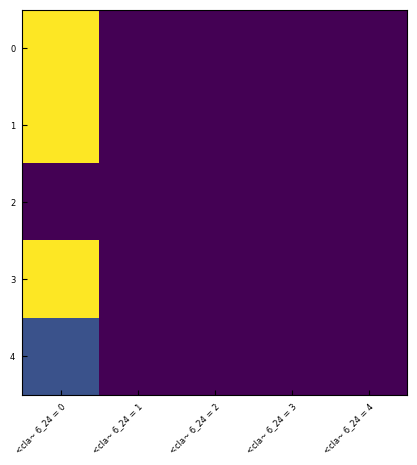

In [3]:
import sys
sys.path.append('tracr/')
from tracr.compiler.compiling import compile_rasp_to_model
from utils.plot import *
import jax
from random import choice
import os
from tracr.rasp import rasp
jax.config.update('jax_platform_name', 'cpu')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

COMPILER_BOS = "compiler_bos"
COMPILER_PAD = "compiler_pad"

#  =================== init program and compile transformer programs ===========================
program, vocab, max_seq_len, assembled_model, compressed_assembled_model, actual_op, ops_range = [None]*7

from data.dataset import choose_vocab_and_ops, build_program_of_length,program_craft_generator
ops_range=(10, 15)
numeric_range=(5, 8)
vocab_size_range=(5, 8)
numeric_inputs_possible=True
max_seq_len = np.random.randint(4, 9)



n_ops, vocab, TARGET_PROGRAM_LENGTH = choose_vocab_and_ops(ops_range=ops_range, vocab_size_range=vocab_size_range, numeric_inputs_possible=numeric_inputs_possible)
print(n_ops, vocab, TARGET_PROGRAM_LENGTH)

program, actual_ops = build_program_of_length(n_ops, vocab, numeric_range, TARGET_PROGRAM_LENGTH)

assembled_model, craft_model, rasp_model = compile_rasp_to_model(
    program, vocab, max_seq_len)



ex_input = [choice(vocab) for i in range(max_seq_len-1)]



from tracr.craft import bases
indices_space = bases.VectorSpaceWithBasis.from_values(
      rasp.indices.label, range(max_seq_len))
input_space = bases.join_vector_spaces(indices_space, craft_model.residual_space)


formatted_input = [COMPILER_BOS] + ex_input

_ONE_DIRECTION = 'one'
_BOS_DIRECTION = [basis.name for basis in craft_model.residual_space.basis if '_selector_width_attn_output' in basis.name][0]


from utils.craft_embeddings import embed_input
embedded_input = embed_input(formatted_input, input_space=input_space, _BOS_DIRECTION=_BOS_DIRECTION, _ONE_DIRECTION=_ONE_DIRECTION)


output_seq = craft_model.apply(embedded_input)



from tracr.compiler import nodes
output_space = bases.VectorSpaceWithBasis(rasp_model.sink[nodes.OUTPUT_BASIS])

outs = output_seq.project(output_space)



output = assembled_model.apply(formatted_input)

def decode_outs(output_seq, output_space):
    outs = output_seq.project(output_space)
    labels = outs.magnitudes.argmax(axis=1)
    return [output_space.basis[i].value for i in labels]

print(f"craft {decode_outs(output_seq, output_space)}")
print(f"JAX: {output.decoded}")



from utils.verbose_craft import plot_basis_dir
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_basis_dir(axs, outs, "")

In [4]:
actual_ops

[Operation(operator=<class 'tracr.rasp.rasp.SelectorWidth'>, inputs=["<class 'tracr.rasp.rasp.Selector'> 2"], output="<class 'tracr.rasp.rasp.SOp'> 5", lambda_name=None),
 Operation(operator=<class 'tracr.rasp.rasp.Select'>, inputs=['tokens', 'tokens', <Comparison.GT: '>'>], output="<class 'tracr.rasp.rasp.Selector'> 1", lambda_name=None),
 Operation(operator=<class 'tracr.rasp.rasp.SelectorWidth'>, inputs=["<class 'tracr.rasp.rasp.Selector'> 1"], output="<class 'tracr.rasp.rasp.SOp'> 3", lambda_name=None),
 Operation(operator=<class 'tracr.rasp.rasp.Map'>, inputs=[functools.partial(<function <lambda> at 0x7f792ba15990>, 5), 'indices'], output="<class 'tracr.rasp.rasp.SOp'> 2", lambda_name='LAM_AND'),
 Operation(operator=<class 'tracr.rasp.rasp.Select'>, inputs=["<class 'tracr.rasp.rasp.SOp'> 2", "<class 'tracr.rasp.rasp.SOp'> 3", <Comparison.LT: '<'>], output="<class 'tracr.rasp.rasp.Selector'> 2", lambda_name=None),
 Operation(operator=<class 'tracr.rasp.rasp.Aggregate'>, inputs=["<c